Goal: Investigate how DSNN fares in a toy problem. 

Compare following models:
- Large dense (same architecture as large sparse, but dense)
- Small dense (same number of params as large sparse, but dense)
- Large sparse
- Large sparse + dynamic sparse


In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys
sys.path.append(os.path.expanduser("~/nta/nupic.research/projects/"))

# general imports
import os
import numpy as np

# torch imports
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as schedulers
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

# nupic research imports
from nupic.research.frameworks.pytorch.image_transforms import RandomNoise
from nupic.torch.modules import KWinners

# local library
from dynamic_sparse.networks import *
from dynamic_sparse.models import *
from dynamic_sparse.common.utils import *

# local files
import math

# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = (12,6)

PATH_TO_WHERE_DATASET_WILL_BE_SAVED = PATH = "~/nta/datasets"

In [10]:
# load dataset
config = (dict(
    dataset_name="MNIST",
    data_dir="~/nta/datasets",
    test_noise=True
))
dataset = Dataset(config)

## Large dense

In [13]:
# load a regular network
network = MLP()
# load a regular base model for training
model = BaseModel(network=network)
model.setup()

In [14]:
%%time
large_dense = model.train(dataset, 3, test_noise=False);

Train acc: 0.8974, Val acc: 0.9518
Train acc: 0.9608, Val acc: 0.9638
Train acc: 0.9704, Val acc: 0.9728
CPU times: user 30.5 s, sys: 591 ms, total: 31.1 s
Wall time: 30 s


## Large sparse

In [15]:
# load a regular network
network = MLP()
# load a regular base model for training
config = dict(
    debug_sparse=True,
    on_perc=0.1,
)
model = SparseModel(network=network, config=config)
model.setup()

In [16]:
%%time
large_sparse = model.train(dataset, 3, test_noise=False);

Train acc: 0.4167, Val acc: 0.9026
Train acc: 0.9185, Val acc: 0.9347
Train acc: 0.9409, Val acc: 0.9452
CPU times: user 30.6 s, sys: 575 ms, total: 31.2 s
Wall time: 30.2 s


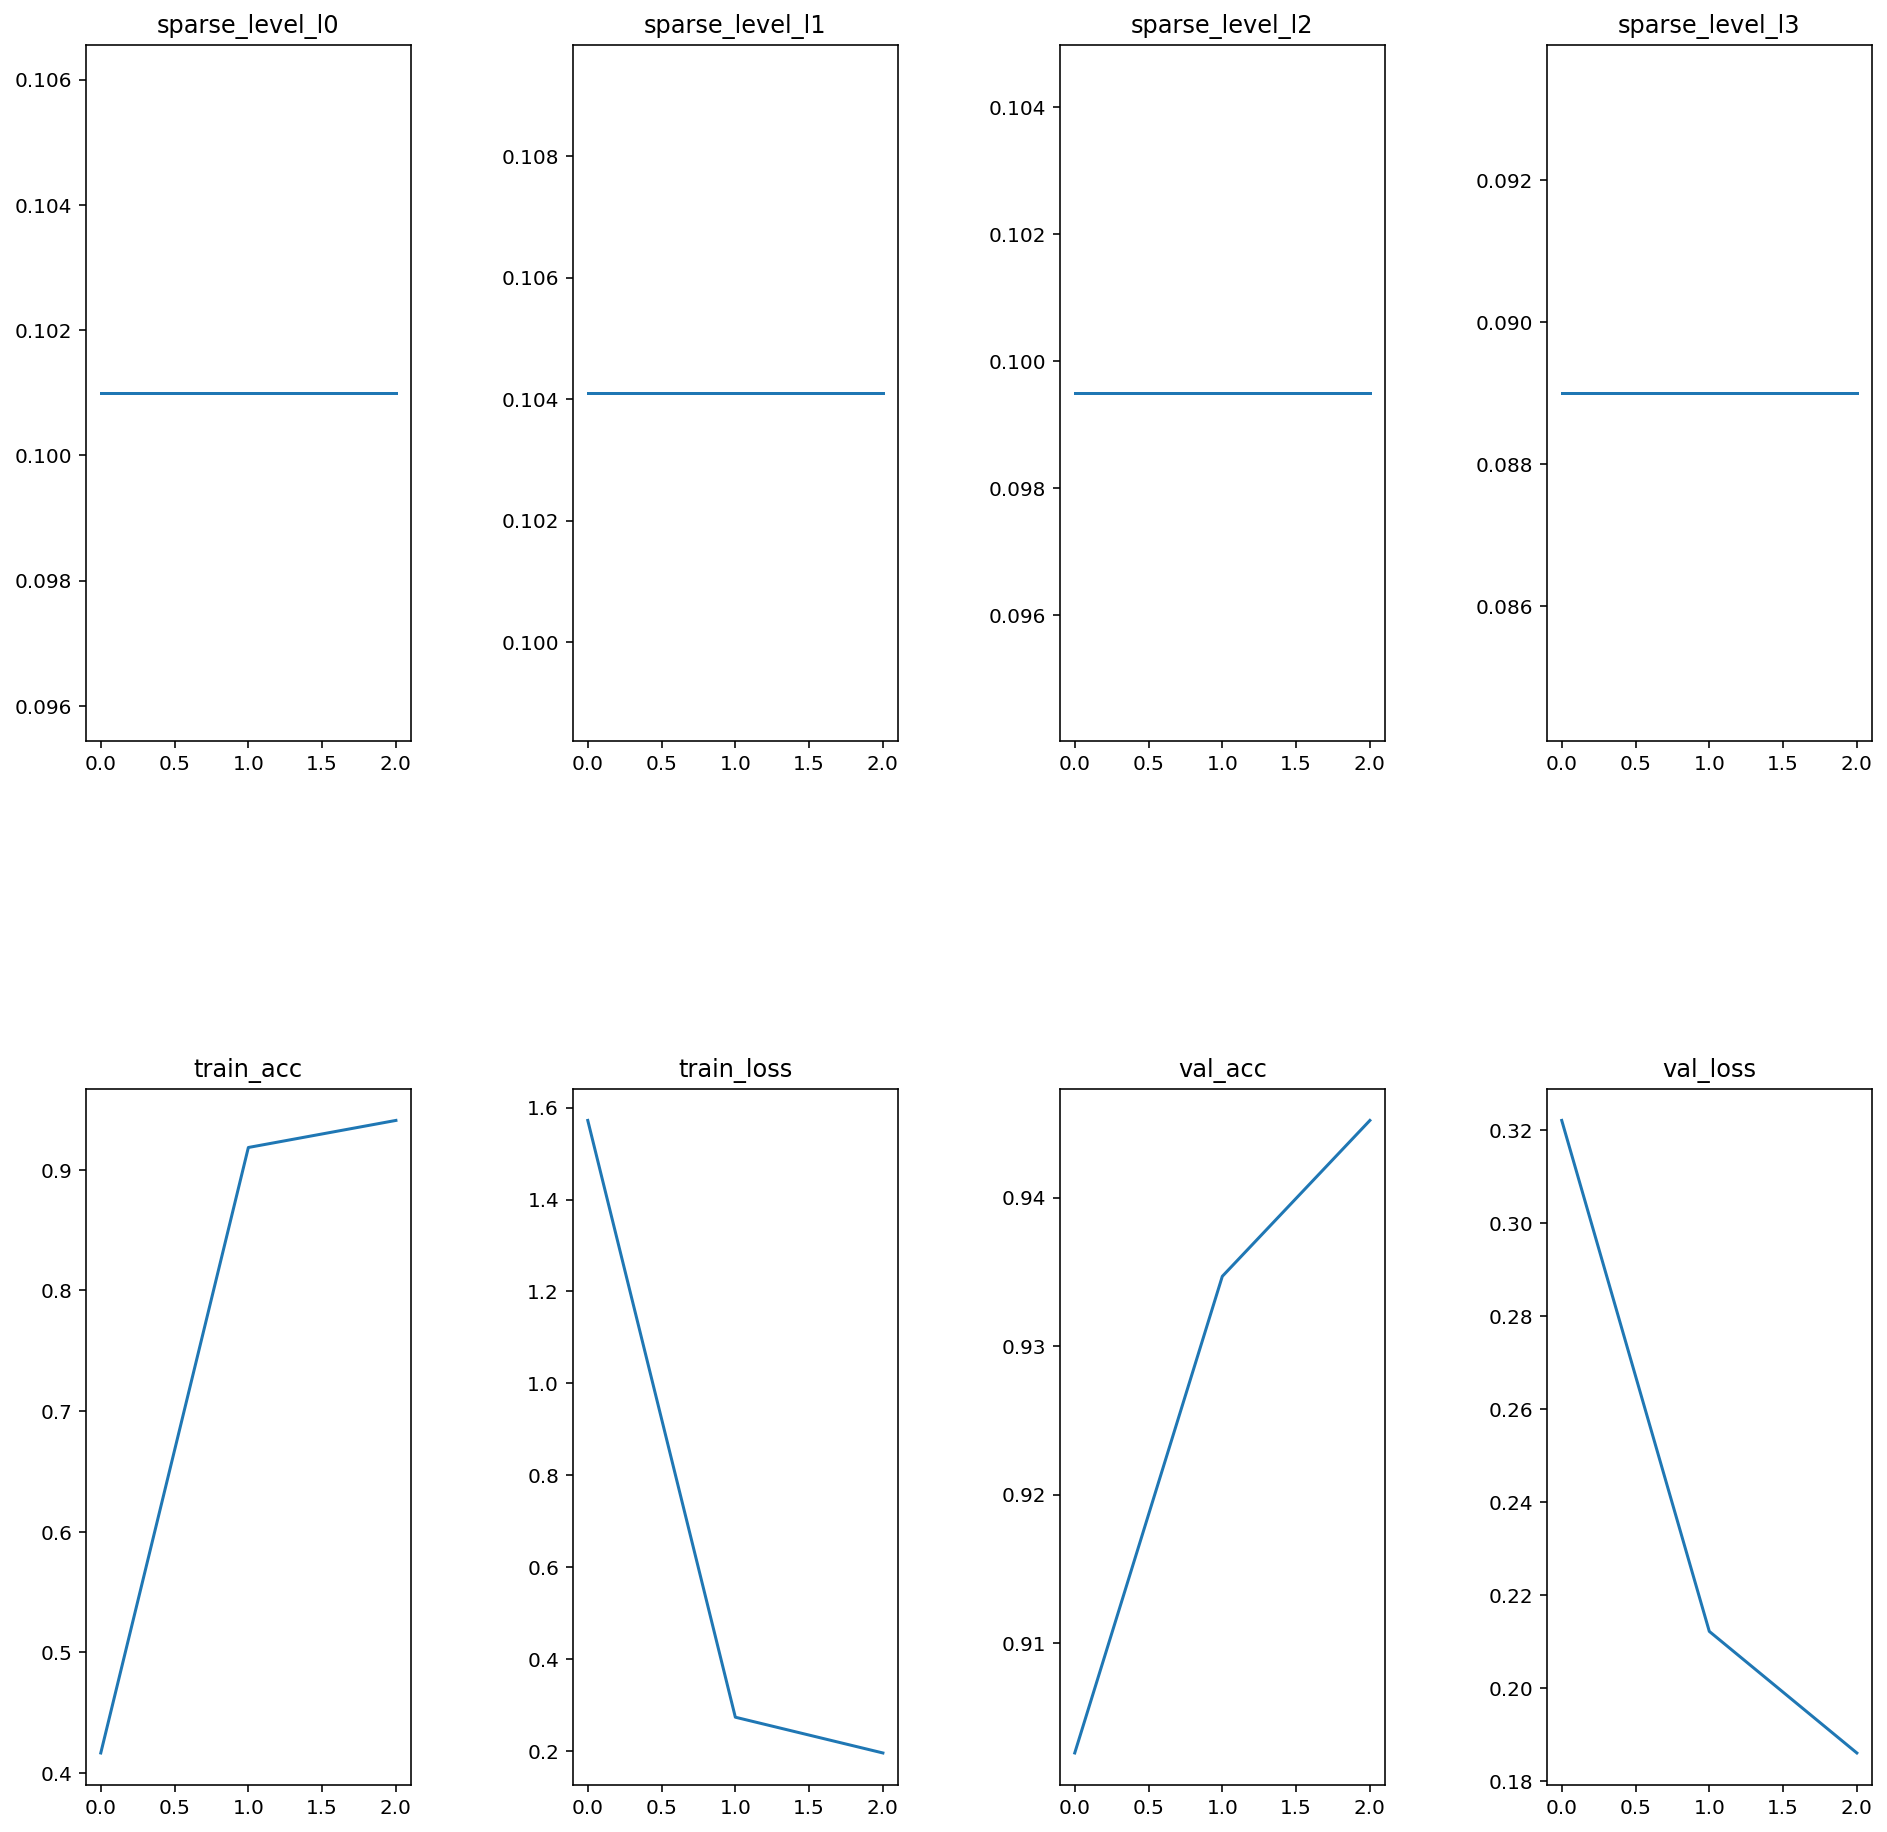

In [17]:
results = large_sparse
h, w = math.ceil(len(results)/4), 4 
combinations = []
for i in range(h):
    for j in range(w):
        combinations.append((i,j))

fig, axs = plt.subplots(h, w, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
fig.set_size_inches(16,16)
for (i, j), k in zip(combinations[:len(results)], sorted(results.keys())):
    axs[i, j].plot(range(len(results[k])), results[k])
    axs[i, j].set_title(k)

## Large dynamic sparse

In [18]:
# load a regular network
network = MLPHeb()
# load a regular base model for training
config = dict(
    weight_prune_perc=0.15,
    hebbian_prune_perc=0.60,
    pruning_es =False,
    pruning_active=True,
    pruning_interval=1,
    debug_sparse=True,
    on_perc=0.1,
)
model = DSNNMixedHeb(network=network, config=config)
model.setup()

# debug sparsity
# [b/a for a,b in zip([784*400, 400*400, 400*400, 400*10], model.num_params)]

In [19]:
%%time
dynamic_sparse = model.train(dataset, 3, test_noise=False);

/Users/lsouza/miniconda3/envs/numenta/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lsouza/miniconda3/envs/numenta/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train acc: 0.4973, Val acc: 0.9123
Train acc: 0.9207, Val acc: 0.9366
Train acc: 0.9376, Val acc: 0.9408
CPU times: user 49.6 s, sys: 1.3 s, total: 50.9 s
Wall time: 50 s


In [20]:
# results.keys(), len(results)

In [21]:
# results

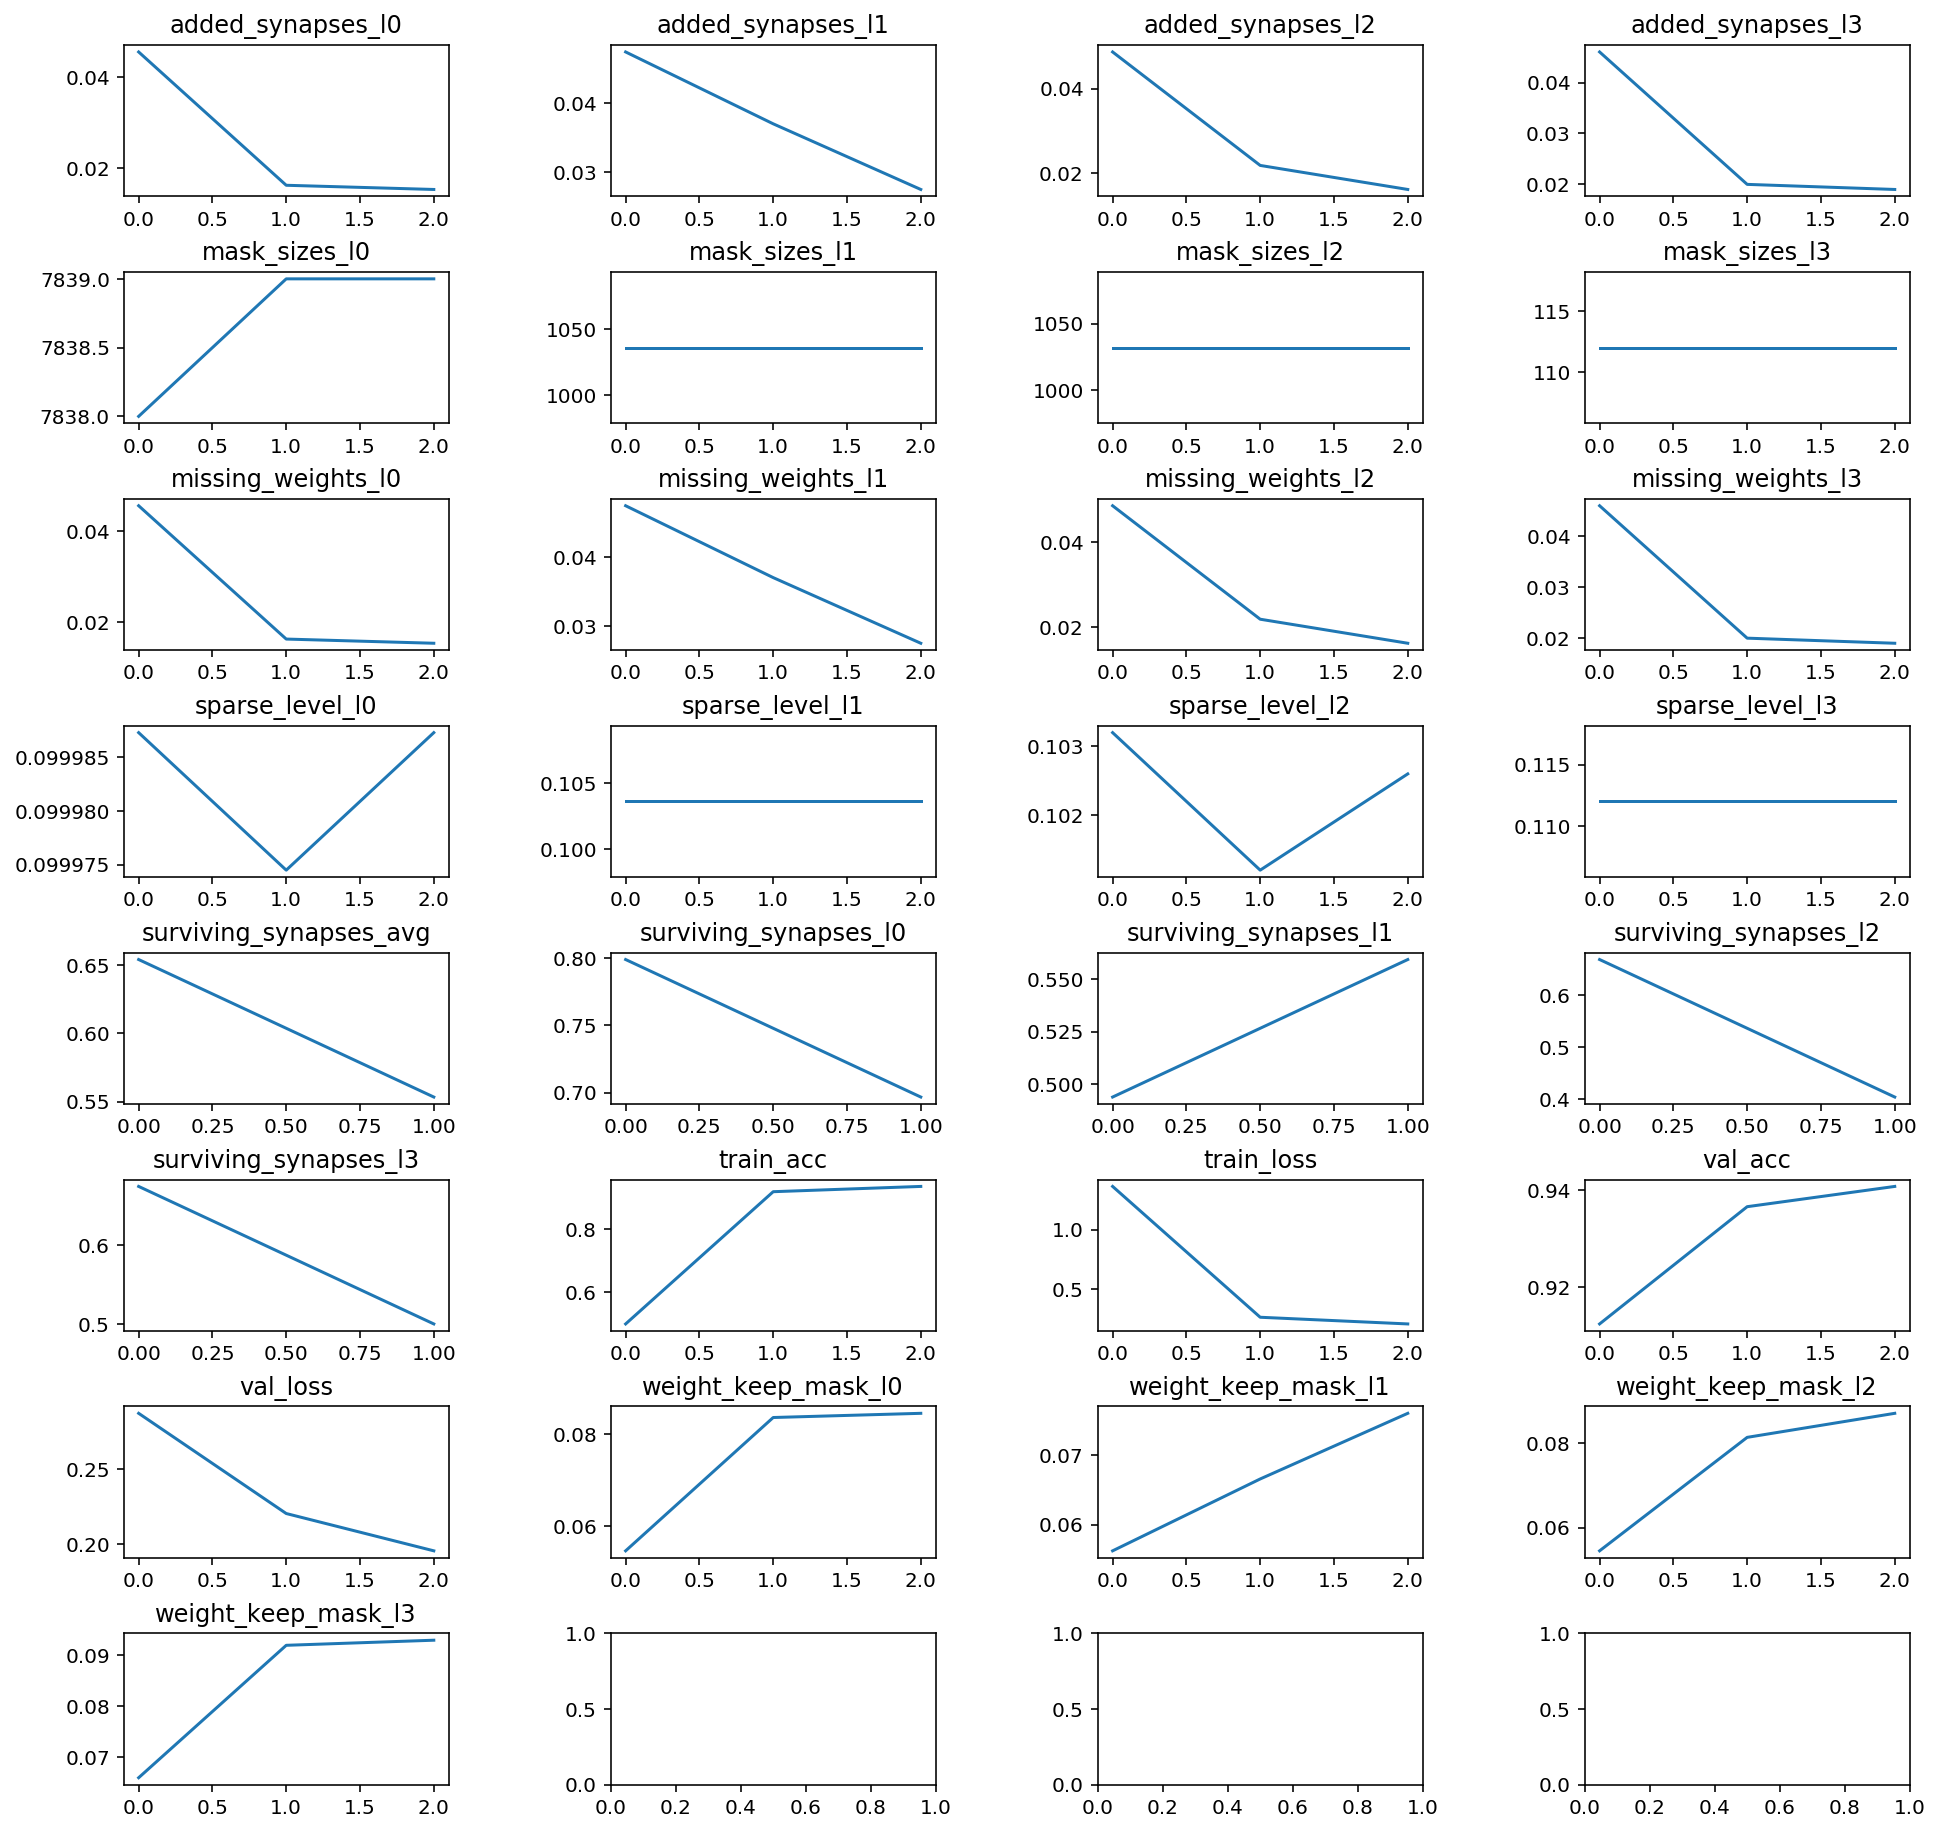

In [22]:
results = dynamic_sparse
h, w = math.ceil(len(results)/4), 4 
combinations = []
for i in range(h):
    for j in range(w):
        combinations.append((i,j))

fig, axs = plt.subplots(h, w, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
fig.set_size_inches(16,16)
for (i, j), k in zip(combinations[:len(results)], sorted(results.keys())):
    axs[i, j].plot(range(len(results[k])), results[k])
    axs[i, j].set_title(k)


## Small dense

In [23]:
# load a regular network
config = dict(
    hidden_sizes = [12,16,23]
)
network = MLP(config=config)
# load a regular base model for training
model = BaseModel(network=network)
model.setup()

In [24]:
%%time
small_dense = model.train(dataset, 3, test_noise=False);

Train acc: 0.8492, Val acc: 0.9104
Train acc: 0.9119, Val acc: 0.9198
Train acc: 0.9213, Val acc: 0.9304
CPU times: user 27.4 s, sys: 410 ms, total: 27.8 s
Wall time: 27.6 s


## Comparing all

In [25]:
from matplotlib import rcParams
rcParams['image.cmap'] = 'Accent'


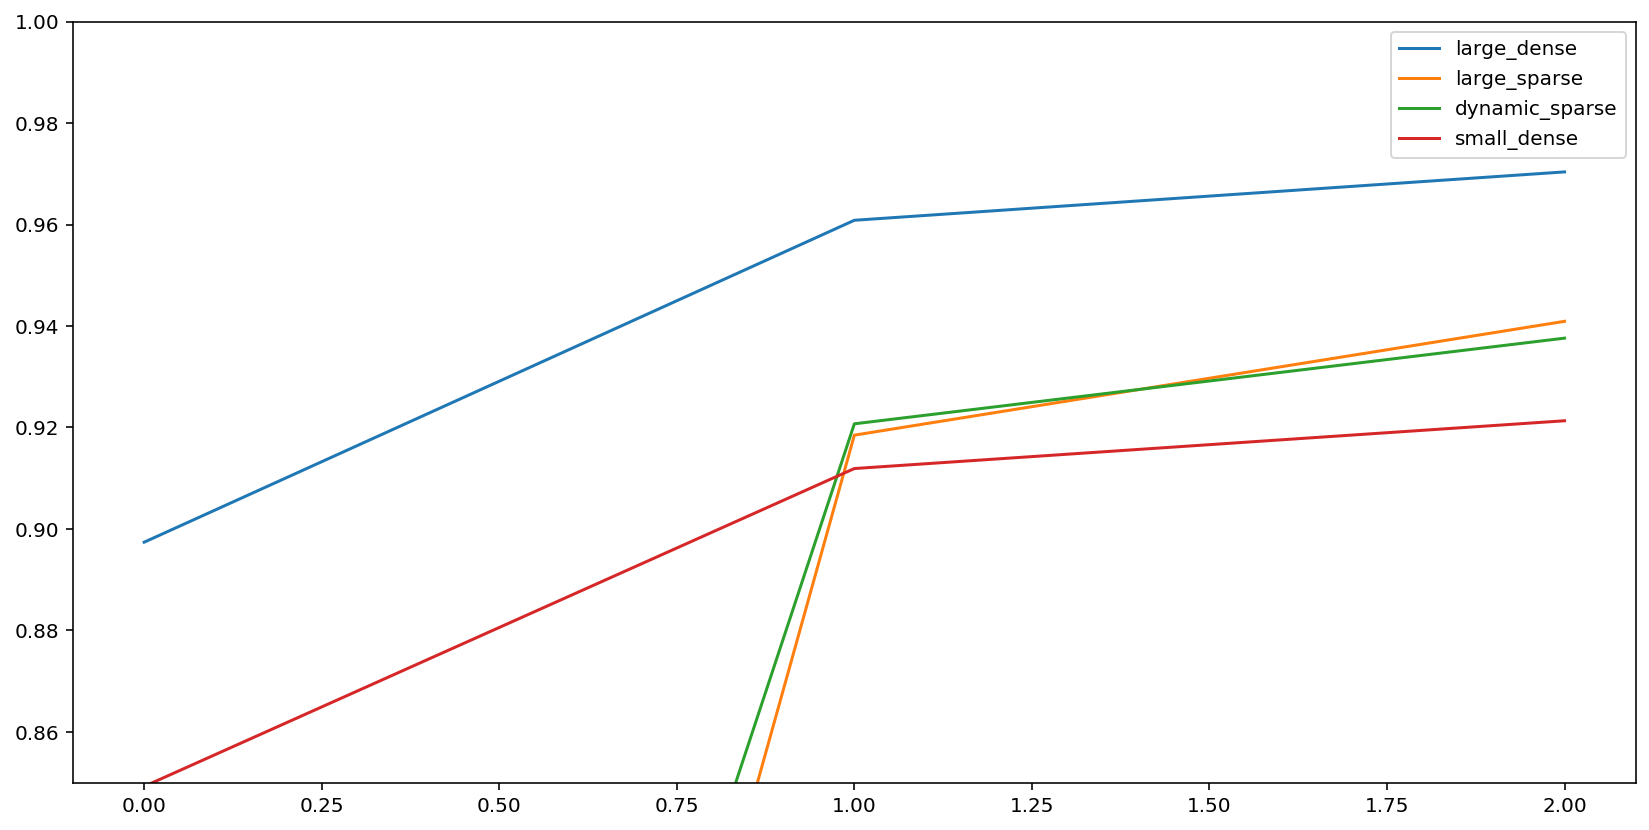

In [26]:
plt.figure(figsize=(14,7))
names = ['large_dense', 'large_sparse', 'dynamic_sparse', 'small_dense']
for name, res in zip(names, [large_dense, large_sparse, dynamic_sparse, small_dense]):
    plt.plot(res['train_acc'], label=name)
plt.legend()
plt.ylim((0.85,1.0));

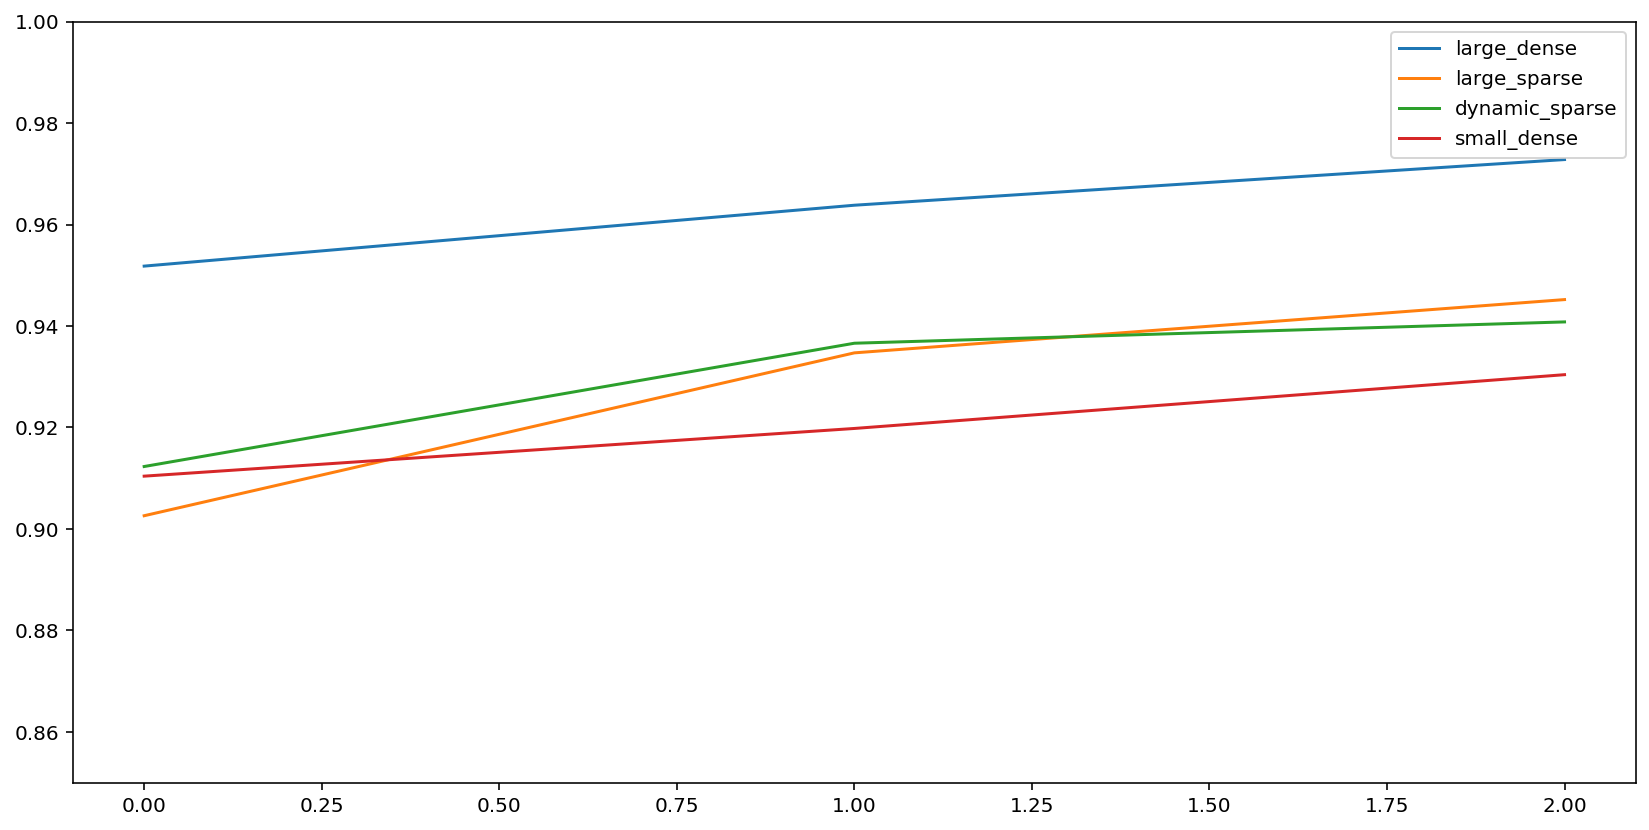

In [27]:
plt.figure(figsize=(14,7))
names = ['large_dense', 'large_sparse', 'dynamic_sparse', 'small_dense']
for name, res in zip(names, [large_dense, large_sparse, dynamic_sparse, small_dense]):
    plt.plot(res['val_acc'], label=name)
plt.legend()
plt.ylim((0.85,1.0));

## Test with kwinners

In [28]:
from models import *
from networks import *

In [29]:
# load dataset
config = (dict(
    dataset_name="MNIST",
    data_dir="~/nta/datasets",
    test_noise=True
))
dataset = Dataset(config)

In [34]:
test_noise = True
use_kwinners = True
epochs = 3
on_perc = 0.1

# large dense
config = dict(hidden_sizes=[100,100,100], use_kwinners=use_kwinners)
network = MLP(config=config)
model = BaseModel(network=network)
model.setup()
print("\nLarge Dense")
large_dense = model.train(dataset, epochs, test_noise=test_noise);

# large sparse
config = dict(hidden_sizes=[100,100,100], use_kwinners=use_kwinners)
network = MLP(config=config)
config = dict(debug_sparse=True, on_perc=on_perc)
model = SparseModel(network=network, config=config)
model.setup()
print("\nLarge Sparse")
large_sparse = model.train(dataset, epochs, test_noise=test_noise);

# dynamic sparse
config = dict(hidden_sizes=[100,100,100], use_kwinners=use_kwinners)
network = MLPHeb(config=config)
config = dict(
    weight_prune_perc=0.15,
    hebbian_prune_perc=0.60,
    pruning_es =False,
    pruning_active=True,
    pruning_interval=1,
    debug_sparse=True,
    on_perc=on_perc,
    hebbian_grow=False    
)
model = DSNNMixedHeb(network=network, config=config)
model.setup()
print("\nDynamic Sparse")
dynamic_sparse = model.train(dataset, epochs, test_noise=test_noise);

# small dense
config = dict(hidden_sizes=[12,16,23], use_kwinners=use_kwinners)
network = MLP(config=config)
# load a regular base model for training
model = BaseModel(network=network)
model.setup()
print("\nSmall Dense")
small_dense = model.train(dataset, epochs, test_noise=test_noise);



Large Dense
Train acc: 0.8790, Val acc: 0.9433, Noise acc: 0.9397
Train acc: 0.9561, Val acc: 0.9577, Noise acc: 0.9536
Train acc: 0.9653, Val acc: 0.9570, Noise acc: 0.9523

Large Sparse
Train acc: 0.4224, Val acc: 0.8801, Noise acc: 0.8628
Train acc: 0.9020, Val acc: 0.9220, Noise acc: 0.8950
Train acc: 0.9295, Val acc: 0.9335, Noise acc: 0.9072

Dynamic Sparse
Train acc: 0.4015, Val acc: 0.8448, Noise acc: 0.8261
Train acc: 0.9087, Val acc: 0.9313, Noise acc: 0.9136
Train acc: 0.9363, Val acc: 0.9416, Noise acc: 0.9245

Small Dense
Train acc: 0.8238, Val acc: 0.8991, Noise acc: 0.8890
Train acc: 0.9090, Val acc: 0.8952, Noise acc: 0.8895
Train acc: 0.9176, Val acc: 0.9131, Noise acc: 0.9046


test_noise = True
use_kwinners = True
epochs = 3
on_perc = 0.1

# large dense
config = dict(hidden_sizes=[100,100,100], use_kwinners=use_kwinners)
network = MLP(config=config)
model = BaseModel(network=network)
model.setup()
print("\nLarge Dense")
large_dense = model.train(dataset, epochs, test_noise=test_noise);

# large sparse
config = dict(hidden_sizes=[100,100,100], use_kwinners=use_kwinners)
network = MLP(config=config)
config = dict(debug_sparse=True, on_perc=on_perc)
model = SparseModel(network=network, config=config)
model.setup()
print("\nLarge Sparse")
large_sparse = model.train(dataset, epochs, test_noise=test_noise);

# dynamic sparse
config = dict(hidden_sizes=[100,100,100], use_kwinners=use_kwinners)
network = MLPHeb(config=config)
config = dict(
    weight_prune_perc=0.15,
    hebbian_prune_perc=0.60,
    pruning_es =False,
    pruning_active=True,
    pruning_interval=1,
    debug_sparse=True,
    on_perc=on_perc,
    hebbian_grow=True    
)
model = DSNNMixedHeb(network=network, config=config)
model.setup()
print("\nDynamic Sparse")
dynamic_sparse = model.train(dataset, epochs, test_noise=test_noise);

# small dense
config = dict(hidden_sizes=[12,16,23], use_kwinners=use_kwinners)
network = MLP(config=config)
# load a regular base model for training
model = BaseModel(network=network)
model.setup()
print("\nSmall Dense")
small_dense = model.train(dataset, epochs, test_noise=test_noise);


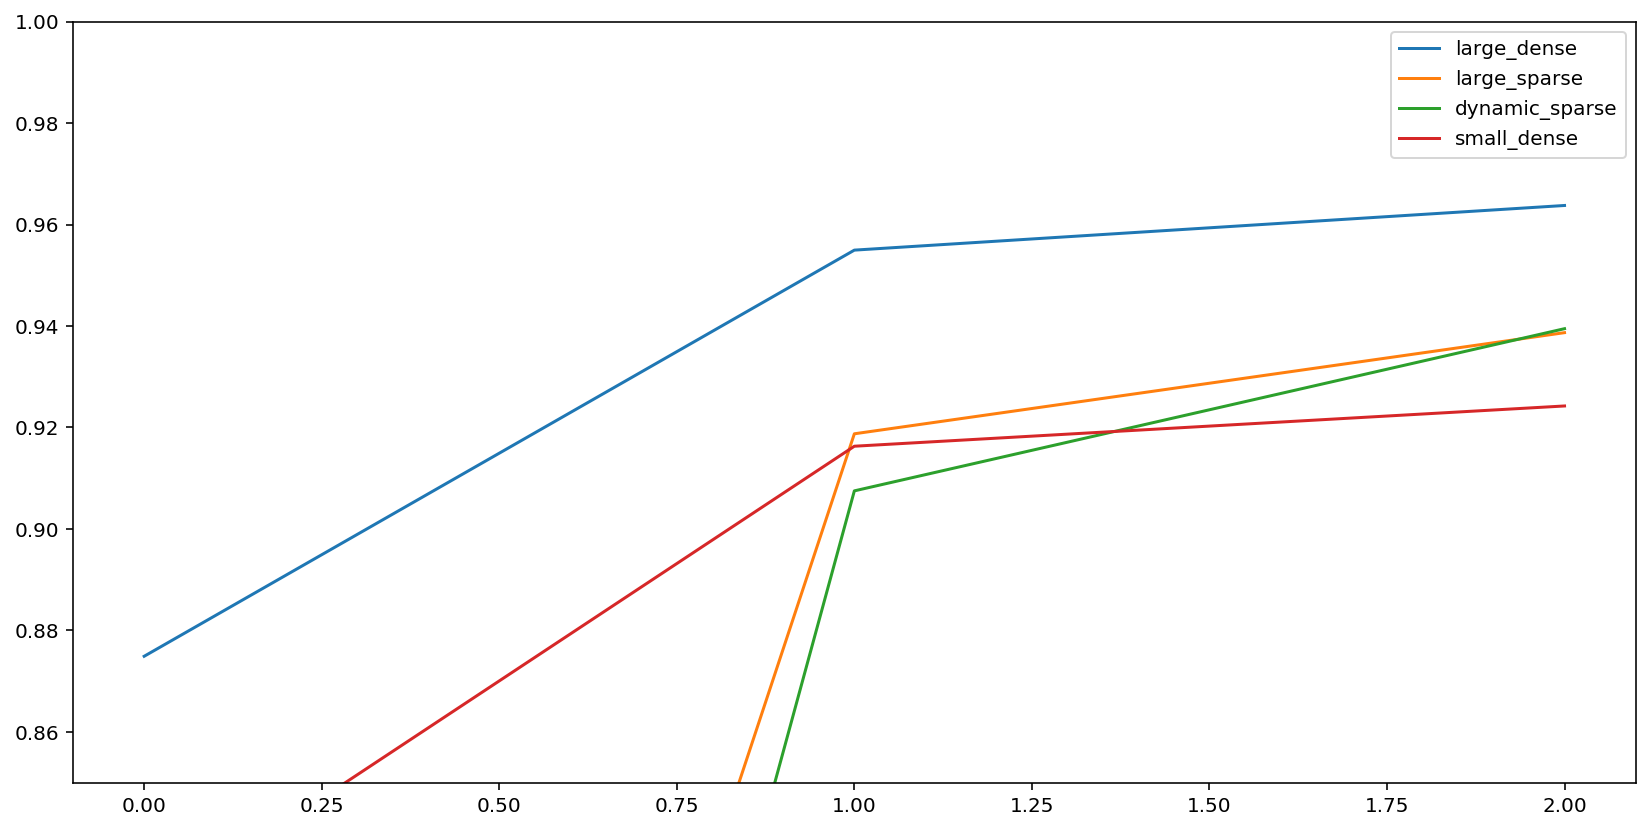

In [31]:
plt.figure(figsize=(14,7))
names = ['large_dense', 'large_sparse', 'dynamic_sparse', 'small_dense']
for name, res in zip(names, [large_dense, large_sparse, dynamic_sparse, small_dense]):
    plt.plot(res['train_acc'], label=name)
plt.legend()
plt.ylim((0.85,1.0));

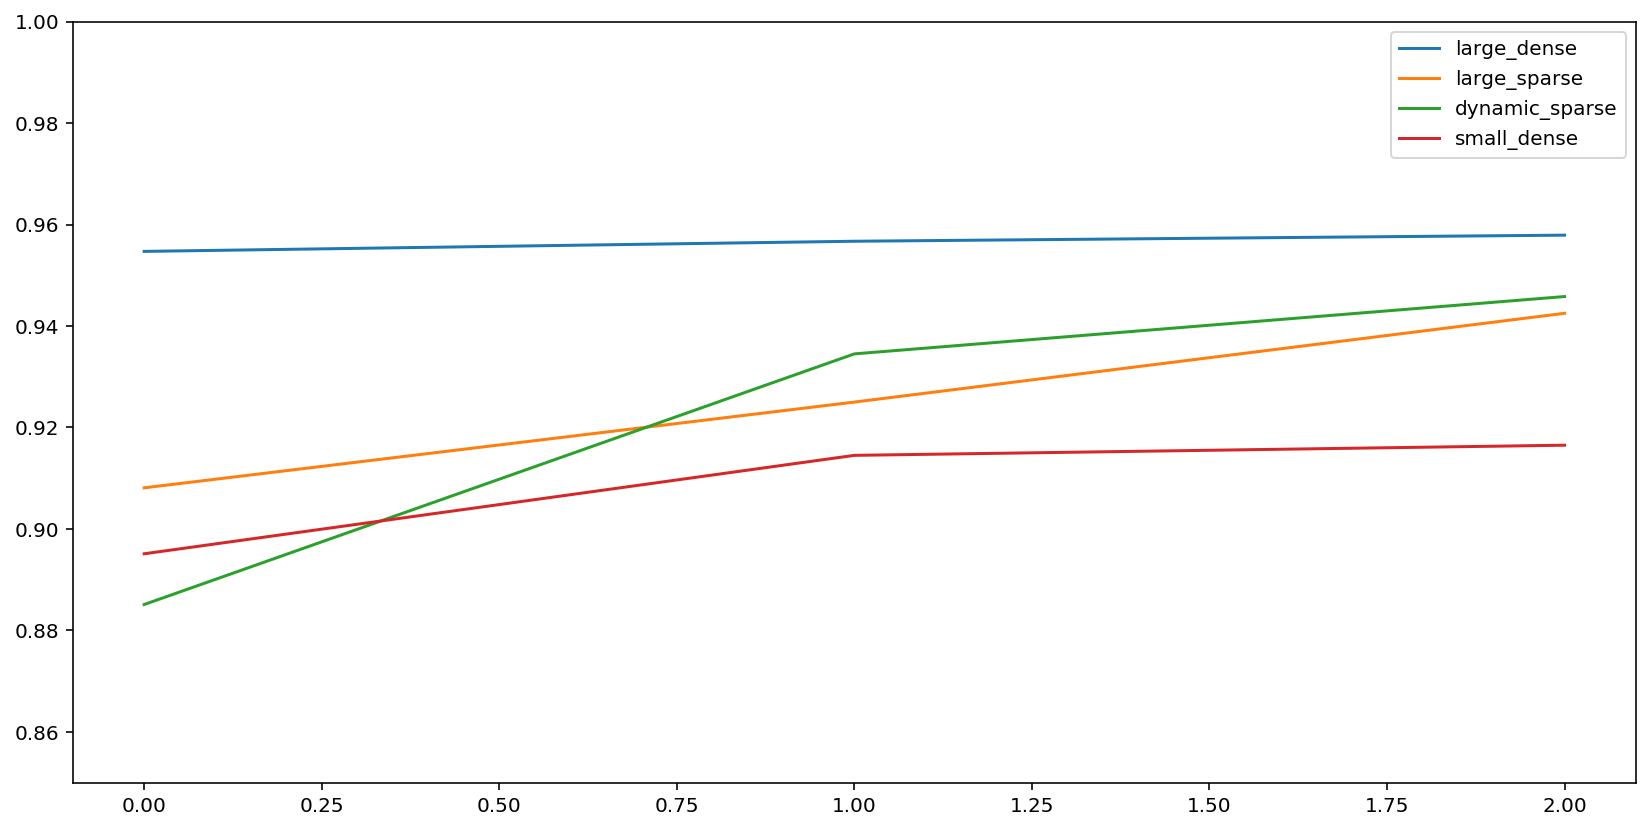

In [32]:
plt.figure(figsize=(14,7))
names = ['large_dense', 'large_sparse', 'dynamic_sparse', 'small_dense']
for name, res in zip(names, [large_dense, large_sparse, dynamic_sparse, small_dense]):
    plt.plot(res['val_acc'], label=name)
plt.legend()
plt.ylim((0.85,1.0));

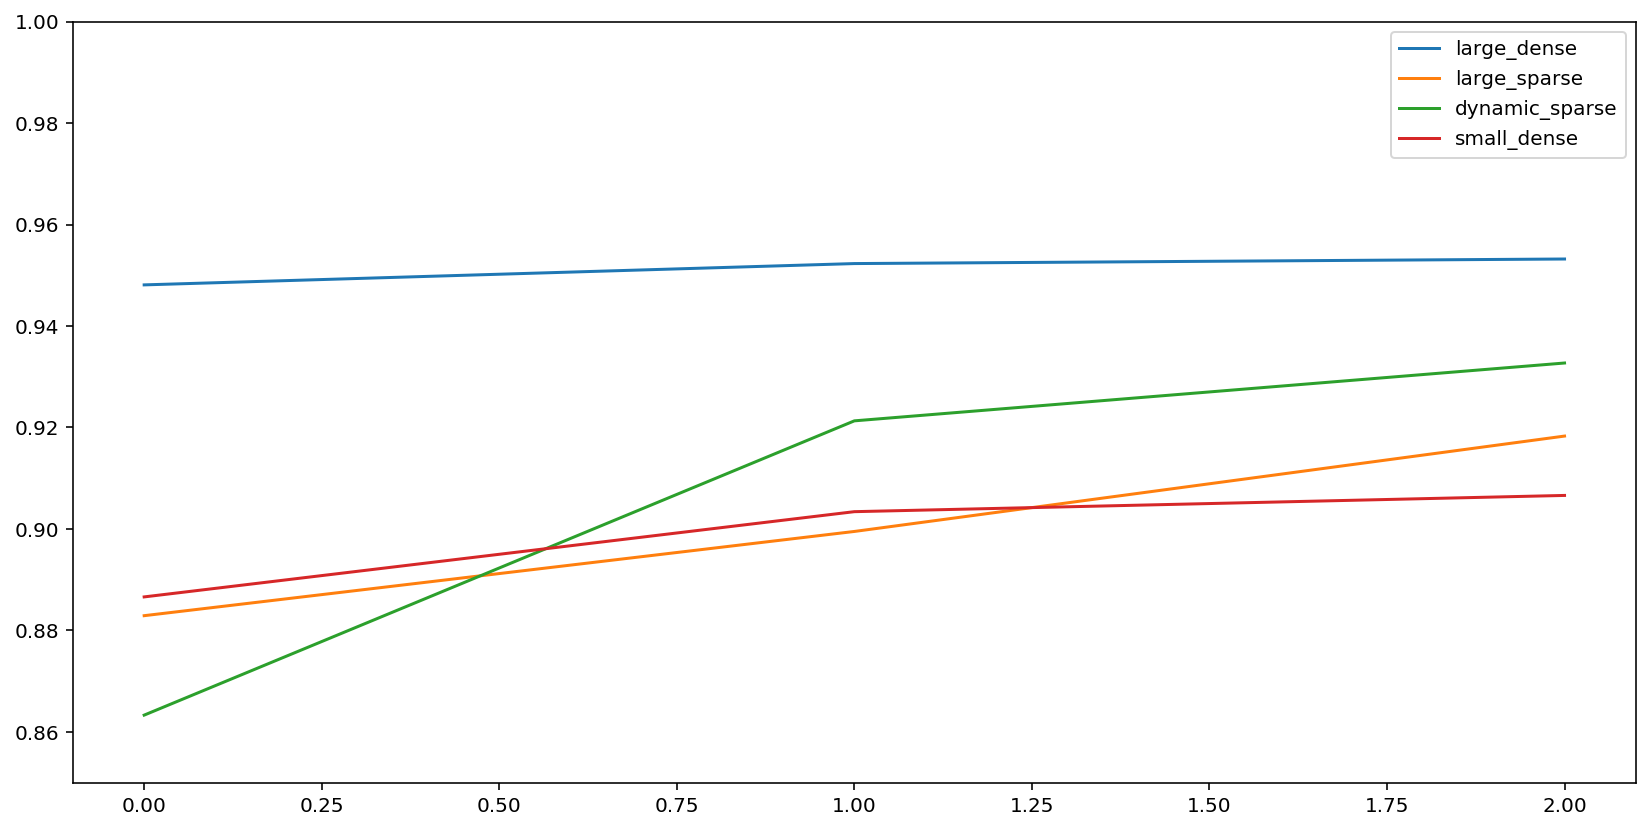

In [33]:
plt.figure(figsize=(14,7))
names = ['large_dense', 'large_sparse', 'dynamic_sparse', 'small_dense']
for name, res in zip(names, [large_dense, large_sparse, dynamic_sparse, small_dense]):
    plt.plot(res['noise_acc'], label=name)
plt.legend()
plt.ylim((0.85,1.0));